<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/TStool/Gluonts_tutorials_Custom_models_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gluonts
!pip install mxnet-cu101

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 8.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 18 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
from typing import List, Optional, Callable, Iterator
from itertools import islice

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from gluonts.dataset.repository.datasets import get_dataset

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [3]:
dataset = get_dataset("electricity")

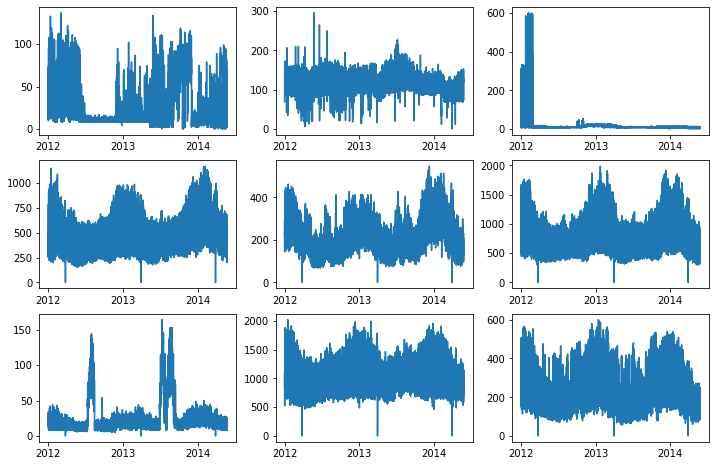

In [5]:
date_formater = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(12,8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx+1)
    t = pd.date_range(start=entry["start"].to_timestamp(), periods=len(entry["target"]), freq=entry["start"].freq)
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

# Probabilistic feed-forward network using PyTorch
We will use a pretty simple model, based on a feed-forward network whose output layer produces the parameters of a parametric distribution. By default, the model will use a Student’s t-distribution, but this can be easily customized via the distr_output constructor argument.


In [4]:
import torch
import torch.nn as nn

In [6]:
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator

In [30]:
def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [29]:
class FeedForwardNetwork(nn.Module):
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        hidden_dimensions: List[int],
        distr_output = StudentTOutput(),
        batch_norm: bool=False,
        scaling: Callable=mean_abs_scaling,
    ) -> None:
        super().__init__()

        assert prediction_length > 0
        assert context_length > 0
        assert len(hidden_dimensions) > 0

        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dimensions = hidden_dimensions
        self.distr_output = distr_output
        self.batch_norm = batch_norm
        self.scaling = scaling

        dimensions = [context_length] + hidden_dimensions[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(out_size))
        modules.append(self.__make_lin(dimensions[-1], prediction_length * hidden_dimensions[-1]))

        self.nn = nn.Sequential(*modules)
        self.args_proj = self.distr_output.get_args_proj(hidden_dimensions[-1])

    @staticmethod
    def __make_lin(dim_in, dim_out):
        lin = nn.Linear(dim_in, dim_out)
        torch.nn.init.uniform_(lin.weight, -0.07, 0.07)
        torch.nn.init.zeros_(lin.bias)
        return lin

    def forward(self, context):
        scale = self.scaling(context)
        scaled_context = context / scale
        nn_out = self.nn(scaled_context)
        nn_out_reshaped = nn_out.reshape(-1, self.prediction_length, self.hidden_dimensions[-1])
        distr_args = self.args_proj(nn_out_reshaped)
        return distr_args, torch.zeros_like(scale), scale

    def get_predictor(self, input_transform, batch_size=32, device=None):
        return PyTorchPredictor(
            prediction_length=self.prediction_length,
            input_names=["past_target"],
            prediction_net=self,
            batch_size=batch_size,
            input_transform=input_transform,
            forecast_generator=DistributionForecastGenerator(self.distr_output),
            device=device,
        )

'''
if __name__ == '__main__':
    pass
    #print(mean_abs_scaling(torch.randn(6,34,2)).shape) #torch.Size([6, 1, 2])
    #test(mean_abs_scaling,torch.randn(6,34,2))




    import numpy as np
    np.random.seed(7)
    context_int = 14
    hidden_dims = [24,32,45,66]
    dimension = [context_int] + hidden_dims[:-1]
    #print(dimension) #[14, 24, 32, 45]
    #print([(input_size, output_size) for input_size, output_size in zip(dimension[:-1],dimension[1:])])
    #[(14, 24), (24, 32), (32, 45)]
    #print(np.random.randint(50, 100,10))1
'''

"\nif __name__ == '__main__':\n    pass\n    #print(mean_abs_scaling(torch.randn(6,34,2)).shape) #torch.Size([6, 1, 2])\n    #test(mean_abs_scaling,torch.randn(6,34,2))\n\n\n\n\n    import numpy as np\n    np.random.seed(7)\n    context_int = 14\n    hidden_dims = [24,32,45,66]\n    dimension = [context_int] + hidden_dims[:-1]\n    #print(dimension) #[14, 24, 32, 45]\n    #print([(input_size, output_size) for input_size, output_size in zip(dimension[:-1],dimension[1:])])\n    #[(14, 24), (24, 32), (32, 45)]\n    #print(np.random.randint(50, 100,10))1\n"

To train the model using PyTorch Lightning, we only need to extend the class with methods that specify how training steps are supposed to work. Please refer to documentation for PyTorch Lightning to know more about the interface you need to implement in order to fully customize the training procedure.

In [9]:
! pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 7.6 MB/s 
     |████████████████████████████████| 596 kB 54.5 MB/s 
     |████████████████████████████████| 140 kB 74.1 MB/s 
     |████████████████████████████████| 419 kB 58.0 MB/s 
     |████████████████████████████████| 1.1 MB 22.9 MB/s 
     |████████████████████████████████| 144 kB 78.2 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 74.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [10]:
import pytorch_lightning as pl

In [31]:
class LightningFeedForwardNetwork(FeedForwardNetwork, pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        context = batch["past_target"]
        target = batch["future_target"]

        assert context.shape[-1] == self.context_length
        assert target.shape[-1] == self.prediction_length

        distr_args, loc, scale = self(context)
        distr = self.distr_output.distribution(distr_args, loc, scale)
        loss = -distr.log_prob(target)

        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

We can now instantiate the training network, and explore its set of parameters.

In [32]:
context_length = 2 * 7 * 24
prediction_length = dataset.metadata.prediction_length
hidden_dimensions = [96, 48]

In [33]:
net = LightningFeedForwardNetwork(
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=hidden_dimensions,
    distr_output=StudentTOutput(),
)

In [15]:
sum(np.prod(p.shape) for p in net.parameters())

32499

In [16]:
for p in net.parameters():
    print(p.shape)

torch.Size([96, 336])
torch.Size([96])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])


## Defining the training data loader
We now set up the data loader which will yield batches of data to train on. Starting from the original dataset, the data loader is configured to apply the following transformation, which does essentially two things: * Replaces nans in the target field with a dummy value (zero), and adds a field indicating which values were actually observed vs imputed this way. * Slices out training instances of a fixed length randomly from the given dataset; these will be stacked into batches by the data loader itself.

In [17]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import AddObservedValuesIndicator, InstanceSplitter, ExpectedNumInstanceSampler, TestSplitSampler

In [34]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [35]:
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [20]:
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify

In [21]:
batch_size = 32
num_batches_per_epoch = 50

In [36]:
data_loader = TrainDataLoader(
    # We cache the dataset, to make training faster
    Cached(dataset.train),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=mask_unobserved + training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

In [23]:
data_loader

## Train the model
We can now train the model using the tooling that PyTorch Lightning provides:

In [37]:
trainer = pl.Trainer(max_epochs=10, gpus=-1 if torch.cuda.is_available() else None)
trainer.fit(net, data_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | nn        | Sequential | 144 K 
1 | args_proj | PtArgProj  | 147   
-----------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.577     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/distributions/studentT.py:82: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  torch.lgamma(0.5 * self.df) -


## Create predictor out of the trained model, and test it
Now we can get the predictor out of our model, and use it to make forecasts.

In [38]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [39]:
predictor_pytorch = net.get_predictor(mask_unobserved + prediction_splitter)

In [40]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

In [41]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, predictor=predictor_pytorch
)

forecasts_pytorch = list(f.to_sample_forecast() for f in forecast_it)
tss_pytorch = list(ts_it)

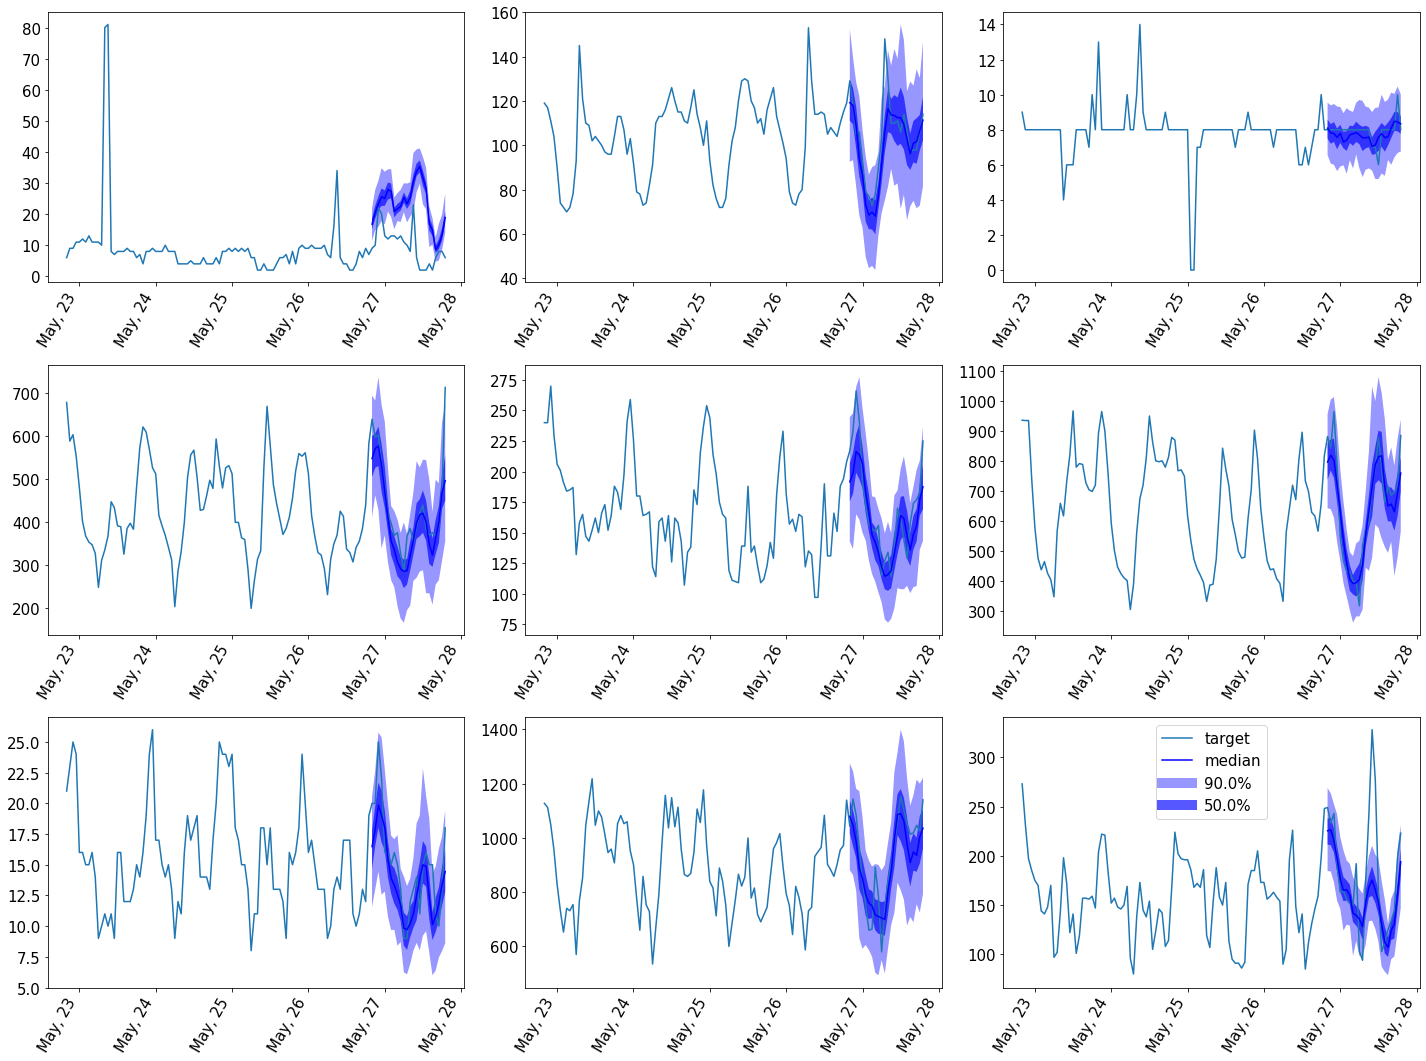

In [42]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx+1)
    ts = ts.copy()
    ts.index = ts.index.to_timestamp()

    plt.plot(ts[-5 * prediction_length:], label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [43]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])


In [44]:
metrics_pytorch, _ = evaluator(tss_pytorch, forecasts_pytorch)
pd.DataFrame.from_records(metrics_pytorch, index=["FeedForward"]).transpose()


Running evaluation: 2247it [00:00, 12441.90it/s]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:353: RuntimeWarning: divide by zero encountered in float_scalars
  float, metrics["abs_target_sum"]
/usr/local/lib/python3.7/dist-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


,FeedForward
Coverage[0.1],6.174900e-02
Coverage[0.5],4.367490e-01
Coverage[0.9],9.037235e-01
MAE_Coverage,3.507516e-02
MAPE,1.499896e-01
MASE,9.895139e-01
MSE,3.843377e+06
MSIS,9.202391e+00
ND,9.416503e-02
NRMSE,8.218992e-01
